<a href="https://colab.research.google.com/github/25i6/semantic-segmentation/blob/main/notebooks/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
!git clone https://github.com/sithu31296/semantic-segmentation
%cd semantic-segmentation
%pip install -e .

Cloning into 'semantic-segmentation'...
remote: Enumerating objects: 801, done.
remote: Counting objects: 100% (798/798), done.
remote: Compressing objects: 100% (317/317), done.
remote: Total 801 (delta 485), reused 756 (delta 474), pack-reused 3 (from 1)
Receiving objects: 100% (801/801), 54.99 MiB | 28.18 MiB/s, done.
Resolving deltas: 100% (485/485), done.
/content/semantic-segmentation
Obtaining file:///content/semantic-segmentation
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=b4e363d1041df64b92a155e7e90e18d3a7939004b848b26f68e890aae534ae6c
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Cre

In [ ]:
import torch
from torchvision import io
from torchvision import transforms as T
from PIL import Image

def show_image(image):
    if image.shape[2] != 3: image = image.permute(1, 2, 0)
    image = Image.fromarray(image.numpy())
    return image

## Show Available Pretrained Models

In [ ]:
from semseg import show_models

show_models()

  No.  Model Names
-----  -------------
    1  SegFormer
    2  Lawin
    3  SFNet
    4  BiSeNetv1
    5  DDRNet
    6  FCHarDNet
    7  BiSeNetv2


## Load a Pretrained Model

Download a pretrained model's weights from the result table (ADE20K, CityScapes, ...) and put it in `checkpoints/pretrained/model_name/`.

In [ ]:
%pip install -U gdown

In [ ]:
import gdown
from pathlib import Path

ckpt = Path('./checkpoints/pretrained/segformer')
ckpt.mkdir(exist_ok=True, parents=True)

url = 'https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT'
output = './checkpoints/pretrained/segformer/segformer.b3.ade.pth'

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT
From (redirected): https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT&confirm=t&uuid=258b9c7b-a435-4f6d-a3d2-598c23508427
To: /content/semantic-segmentation/checkpoints/pretrained/segformer/segformer.b3.ade.pth
100%|██████████| 190M/190M [00:01<00:00, 111MB/s]


'./checkpoints/pretrained/segformer/segformer.b3.ade.pth'

In [ ]:
from semseg.models import *

model = eval('SegFormer')(
    backbone='MiT-B3',
    num_classes=150
)

try:
    model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b3.ade.pth', map_location='cpu'))
except:
    print("Download a pretrained model's weights from the result table.")
model.eval()

print('Loaded Model')

<ipython-input-25-288208e8de82>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b3.ade.pth', ma

Loaded Model


## Simple Image Inference

### Load Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


データの形式が4Dとか言われたら、ここからゆっくりやり直す。

torch.Size([3, 512, 512])


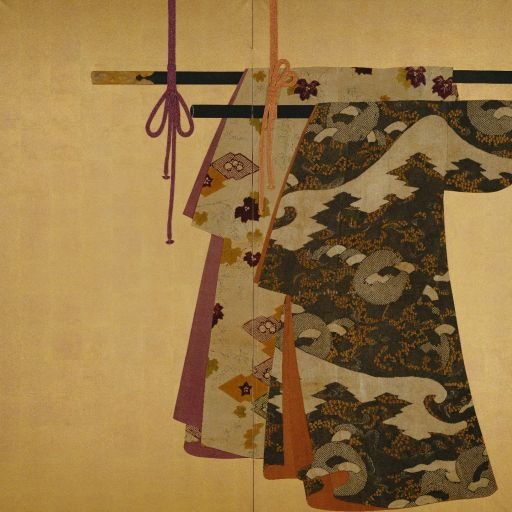

In [ ]:
image_path = '/content/drive/MyDrive/2025autum/02_Special_Laboratory/02_kosode/junk_box/14-D-201350-100-0003.jpg'#最後がjpgとかじゃなくて日本語だと一個下のブロックでエラー
image = io.read_image(image_path)
print(image.shape)
show_image(image)

### Preprocess

In [ ]:
# resize
image = T.CenterCrop((512, 512))(image)
# scale to [0.0, 1.0]
image = image.float() / 255
# normalize
image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
# add batch size
image = image.unsqueeze(0)
image.shape

torch.Size([1, 3, 512, 512])

### Model Forward

In [ ]:
with torch.inference_mode():
    seg = model(image)
seg.shape

torch.Size([1, 150, 512, 512])

### Postprocess

In [ ]:
seg = seg.softmax(1).argmax(1).to(int)
#
seg_unique = seg.unique()
seg.unique()

tensor([ 0,  7,  8, 12, 18, 22, 39, 92])

In [ ]:
from semseg.datasets import *

palette = eval('ADE20K').PALETTE

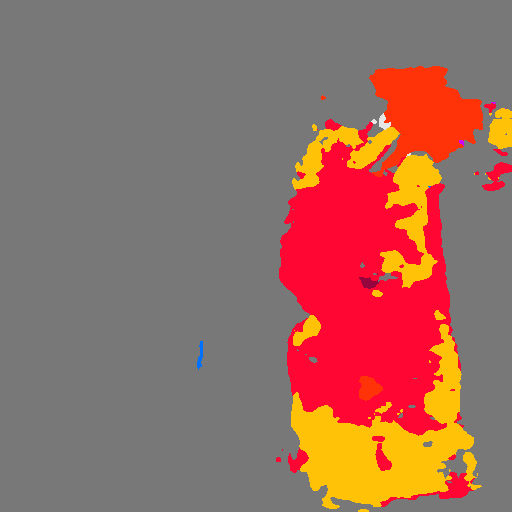

In [ ]:
seg_map = palette[seg].squeeze().to(torch.uint8)
show_image(seg_map)

評価

In [ ]:
import json
import numpy as np
#import torch
import cv2
import matplotlib.pyplot as plt
from semseg.datasets import ADE20K

def load_labelme_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def compute_metrics(seg, gt):
    pixel_accuracy = (seg == gt).sum() / gt.size
    intersection = np.logical_and(seg == gt, gt > 0).sum()
    union = np.logical_or(seg > 0, gt > 0).sum()
    miou = intersection / (union + 1e-10)
    return pixel_accuracy, miou

def visualize_segmentation(seg, palette):
    seg_map = np.array(palette)[seg.squeeze()]
    return seg_map.astype(np.uint8)

def overlay_labels(image, seg, seg_unique):
    for label in seg_unique:
        mask = (seg == label)
        y, x = np.where(mask)
        if len(x) > 0 and len(y) > 0:
            cx, cy = int(x.mean()), int(y.mean())
            cv2.putText(image, str(label), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    return image

def main(json_file, seg_tensor):
    labelme_data = load_labelme_json(json_file)
    gt = np.array(labelme_data['shapes'])
    seg = seg_tensor.softmax(1).argmax(1).cpu().numpy()
    seg_unique = np.unique(seg)
    palette = ADE20K.PALETTE
    seg_map = visualize_segmentation(seg, palette)
    map_unique = np.unique(seg_map.reshape(-1, seg_map.shape[-1]), axis=0)
    seg_map = overlay_labels(seg_map, seg, seg_unique)
    pixel_accuracy, miou = compute_metrics(seg, gt)
    print(f'Pixel Accuracy: {pixel_accuracy:.4f}, mIoU: {miou:.4f}')
    plt.imshow(seg_map)
    plt.axis('off')
    plt.show()

# 使用例（適切な json_file と seg_tensor を指定する）
main("/content/drive/MyDrive/2025autum/02_Special_Laboratory/02_kosode/junk_box/14-D-201350-100-0057.json", seg)


RuntimeError: "softmax_kernel_impl" not implemented for 'Long'

In [ ]:
import json
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from semseg.datasets import ADE20K

def load_labelme_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def compute_metrics(seg, gt):
    pixel_accuracy = (seg == gt).sum() / gt.size
    intersection = np.logical_and(seg == gt, gt > 0).sum()
    union = np.logical_or(seg > 0, gt > 0).sum()
    miou = intersection / (union + 1e-10)
    return pixel_accuracy, miou
"""
def visualize_segmentation(seg, palette):
    seg_map = np.array(palette)[seg.squeeze()]
    return seg_map.astype(np.uint8)

def overlay_labels(image, seg, seg_unique):
    for label in seg_unique:
        mask = (seg == label)
        y, x = np.where(mask)
        if len(x) > 0 and len(y) > 0:
            cx, cy = int(x.mean()), int(y.mean())
            cv2.putText(image, str(label), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    return image
"""
def main(json_file, seg_tensor):
    labelme_data = load_labelme_json(json_file)
    gt = np.array(labelme_data['shapes'])

    # 修正: seg_tensor を float32 に変換
    seg = seg_tensor.to(torch.float32).softmax(1).argmax(1).cpu().numpy()

    seg_unique = np.unique(seg)
    palette = ADE20K.PALETTE
    #seg_map = visualize_segmentation(seg, palette)
    map_unique = np.unique(seg_map.reshape(-1, seg_map.shape[-1]), axis=0)
    #seg_map = overlay_labels(seg_map, seg, seg_unique)
    pixel_accuracy, miou = compute_metrics(seg, gt)
    print(f'Pixel Accuracy: {pixel_accuracy:.4f}, mIoU: {miou:.4f}')
    plt.imshow(seg_map)
    plt.axis('off')
    plt.show()

# 使用例（適切な json_file と seg_tensor を指定する）
main("/content/drive/MyDrive/2025autum/02_Special_Laboratory/02_kosode/junk_box/14-D-201350-100-0057.json", seg)


ValueError: operands could not be broadcast together with shapes (1,512) (26,) 

In [ ]:
import json
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from semseg.datasets import ADE20K

def load_labelme_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def compute_metrics(seg, gt):
    pixel_accuracy = (seg == gt).sum() / gt.size
    intersection = np.logical_and(seg == gt, gt > 0).sum()
    union = np.logical_or(seg > 0, gt > 0).sum()
    miou = intersection / (union + 1e-10)
    return pixel_accuracy, miou
"""
def visualize_segmentation(seg, palette):
    seg_map = np.array(palette)[seg.squeeze()]
    return seg_map.astype(np.uint8)

def overlay_labels(image, seg, seg_unique):
    for label in seg_unique:
        mask = (seg == label)
        y, x = np.where(mask)
        if len(x) > 0 and len(y) > 0:
            cx, cy = int(x.mean()), int(y.mean())
            cv2.putText(image, str(label), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    return image
"""
def main(json_file, seg_tensor):
    labelme_data = load_labelme_json(json_file)

    # `gt` を適切な形状のマスク画像として変換
    height, width = seg_tensor.shape[-2], seg_tensor.shape[-1]
    gt = np.zeros((height, width), dtype=np.uint8)

    for shape in labelme_data['shapes']:
        points = np.array(shape['points'], dtype=np.int32)
        label = int(shape['label']) if shape['label'].isdigit() else 1  # 非数値ラベルのデフォルト値
        cv2.fillPoly(gt, [points], label)

    # 修正: seg_tensor を float32 に変換して softmax を適用
    seg = seg_tensor.to(torch.float32).softmax(dim=1).argmax(dim=1).cpu().numpy().squeeze()

    seg_unique = np.unique(seg)
    palette = ADE20K.PALETTE
    seg_map = visualize_segmentation(seg, palette)
    map_unique = np.unique(seg_map.reshape(-1, seg_map.shape[-1]), axis=0)
    seg_map = overlay_labels(seg_map, seg, seg_unique)

    # `gt` の形状が正しく (512,512) になっているか確認
    print(f"seg shape: {seg.shape}, gt shape: {gt.shape}")

    pixel_accuracy, miou = compute_metrics(seg, gt)
    print(f'Pixel Accuracy: {pixel_accuracy:.4f}, mIoU: {miou:.4f}')

    plt.imshow(seg_map)
    plt.axis('off')
    plt.show()


# 使用例（適切な json_file と seg_tensor を指定する）
main("/content/drive/MyDrive/2025autum/02_Special_Laboratory/02_kosode/junk_box/14-D-201350-100-0057.json", seg)


IndexError: index 361 is out of bounds for axis 0 with size 150

追加

実行できる。

seg shape: (512,), gt shape: (512, 512)
Pixel Accuracy: 0.4475, mIoU: 0.0000


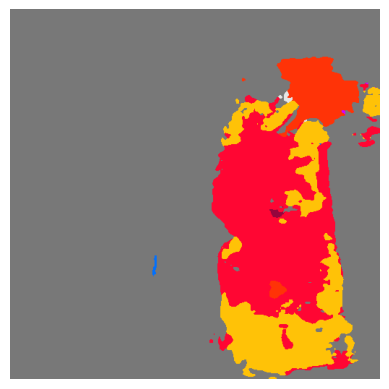

In [ ]:
import json
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from semseg.datasets import ADE20K

def load_labelme_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def compute_metrics(seg, gt):
    pixel_accuracy = (seg == gt).sum() / gt.size
    intersection = np.logical_and(seg == gt, gt > 0).sum()
    union = np.logical_or(seg > 0, gt > 0).sum()
    miou = intersection / (union + 1e-10)
    return pixel_accuracy, miou

"""def visualize_segmentation(seg, palette):
    seg_map = np.array(palette)[seg.squeeze()]
    return seg_map.astype(np.uint8)

def overlay_labels(image, seg, seg_unique):
    for label in seg_unique:
        mask = (seg == label)
        y, x = np.where(mask)
        if len(x) > 0 and len(y) > 0:
            cx, cy = int(x.mean()), int(y.mean())
            cv2.putText(image, str(label), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    return image
"""
def main(json_file, seg_tensor):
    labelme_data = load_labelme_json(json_file)

    # `gt` を (512, 512) のマスク画像として変換
    height, width = seg_tensor.shape[-2], seg_tensor.shape[-1]
    gt = np.zeros((height, width), dtype=np.uint8)

    for shape in labelme_data['shapes']:
        points = np.array(shape['points'], dtype=np.int32)
        label = int(shape['label']) if shape['label'].isdigit() else 1  # ラベルが数値でない場合は1に
        cv2.fillPoly(gt, [points], label)

    # 修正: seg_tensor を float32 に変換して softmax を適用
    seg = seg_tensor.to(torch.float32).softmax(dim=1).argmax(dim=1).cpu().numpy().squeeze()

    # 形状確認
    print(f"seg shape: {seg.shape}, gt shape: {gt.shape}")  # 両方とも (512, 512) であるべき

    seg_unique = np.unique(seg)
    palette = ADE20K.PALETTE
    #seg_map = visualize_segmentation(seg, palette)
    #map_unique = np.unique(seg_map.reshape(-1, seg_map.shape[-1]), axis=0)
    #seg_map = overlay_labels(seg_map, seg, seg_unique)

    pixel_accuracy, miou = compute_metrics(seg, gt)
    print(f'Pixel Accuracy: {pixel_accuracy:.4f}, mIoU: {miou:.4f}')

    plt.imshow(seg_map)
    plt.axis('off')
    plt.show()

# 使用例（適切な json_file と seg_tensor を指定する）
main("/content/drive/MyDrive/2025autum/02_Special_Laboratory/02_kosode/junk_box/14-D-201350-100-0057.json", seg)


seg shape: (512,), gt shape: (512, 512)
Pixel Accuracy: 0.4475, mIoU: 0.0000


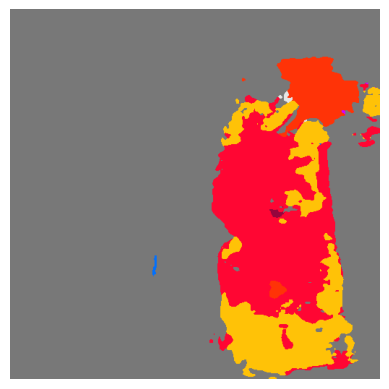

In [ ]:
import json
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from semseg.datasets import ADE20K

def load_labelme_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def compute_metrics(seg, gt):
    pixel_accuracy = (seg == gt).sum() / gt.size
    intersection = np.logical_and(seg == gt, gt > 0).sum()
    union = np.logical_or(seg > 0, gt > 0).sum()
    miou = intersection / (union + 1e-10)
    return pixel_accuracy, miou

"""def visualize_segmentation(seg, palette):
    seg_map = np.array(palette)[seg.squeeze()]
    return seg_map.astype(np.uint8)

def overlay_labels(image, seg, seg_unique):
    for label in seg_unique:
        mask = (seg == label)
        y, x = np.where(mask)
        if len(x) > 0 and len(y) > 0:
            cx, cy = int(x.mean()), int(y.mean())
            cv2.putText(image, str(label), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    return image
"""
def main(json_file, seg_tensor):
    labelme_data = load_labelme_json(json_file)

    # `gt` を (512, 512) のマスク画像として変換
    height, width = seg_tensor.shape[-2], seg_tensor.shape[-1]
    gt = np.zeros((height, width), dtype=np.uint8)

    for shape in labelme_data['shapes']:
        points = np.array(shape['points'], dtype=np.int32)
        label = int(shape['label']) if shape['label'].isdigit() else 1  # ラベルが数値でない場合は1に
        cv2.fillPoly(gt, [points], label)

    # 修正: seg_tensor を float32 に変換して softmax を適用
    seg = seg_tensor.to(torch.float32).softmax(dim=1).argmax(dim=1).cpu().numpy().squeeze()

    # 形状確認
    print(f"seg shape: {seg.shape}, gt shape: {gt.shape}")  # 両方とも (512, 512) であるべき

    seg_unique = np.unique(seg)
    palette = ADE20K.PALETTE
    #seg_map = visualize_segmentation(seg, palette)
    #map_unique = np.unique(seg_map.reshape(-1, seg_map.shape[-1]), axis=0)
    #seg_map = overlay_labels(seg_map, seg, seg_unique)

    pixel_accuracy, miou = compute_metrics(seg, gt)
    print(f'Pixel Accuracy: {pixel_accuracy:.4f}, mIoU: {miou:.4f}')

    plt.imshow(seg_map)
    plt.axis('off')
    plt.show()

# 使用例（適切な json_file と seg_tensor を指定する）
main("/content/drive/MyDrive/2025autum/02_Special_Laboratory/02_kosode/junk_box/14-D-201350-100-0057.json", seg)


In [ ]:
import json
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from semseg.datasets import ADE20K

def load_labelme_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def compute_metrics(seg, gt):
    pixel_accuracy = (seg == gt).sum() / gt.size
    intersection = np.logical_and(seg == gt, gt > 0).sum()
    union = np.logical_or(seg > 0, gt > 0).sum()
    miou = intersection / (union + 1e-10)
    return pixel_accuracy, miou

"""def visualize_segmentation(seg, palette):
    seg_map = np.array(palette)[seg.squeeze()]
    return seg_map.astype(np.uint8)

def overlay_labels(image, seg, seg_unique):
    for label in seg_unique:
        mask = (seg == label)
        y, x = np.where(mask)
        if len(x) > 0 and len(y) > 0:
            cx, cy = int(x.mean()), int(y.mean())
            cv2.putText(image, str(label), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    return image
"""
def main(json_file, seg_tensor):
    labelme_data = load_labelme_json(json_file)

    # `gt` を (512, 512) のマスク画像として変換
    height, width = seg_tensor.shape[-2], seg_tensor.shape[-1]
    gt = np.zeros((height, width), dtype=np.uint8)

    for shape in labelme_data['shapes']:
        points = np.array(shape['points'], dtype=np.int32)
        label = int(shape['label']) if shape['label'].isdigit() else 1  # ラベルが数値でない場合は1に
        cv2.fillPoly(gt, [points], label)

    # 修正: seg_tensor を float32 に変換して softmax を適用し、明示的に shape を (512, 512) に維持
    seg = seg_tensor.to(torch.float32).softmax(dim=1).argmax(dim=1).cpu().numpy()

    # `seg` の形状を確認
    print(f"Before squeeze: seg shape = {seg.shape}")  # (1, 512, 512) のはず

    if seg.shape[0] == 1:
        seg = seg[0]  # (512, 512) に変換

    # 形状確認
    print(f"After squeeze: seg shape = {seg.shape}, gt shape = {gt.shape}")  # 両方とも (512, 512) になるはず

    seg_unique = np.unique(seg)
    palette = ADE20K.PALETTE
    seg_map = visualize_segmentation(seg, palette)
    map_unique = np.unique(seg_map.reshape(-1, seg_map.shape[-1]), axis=0)
    seg_map = overlay_labels(seg_map, seg, seg_unique)

    pixel_accuracy, miou = compute_metrics(seg, gt)
    print(f'Pixel Accuracy: {pixel_accuracy:.4f}, mIoU: {miou:.4f}')

    plt.imshow(seg_map)
    plt.axis('off')
    plt.show()


# 使用例（適切な json_file と seg_tensor を指定する）
main("/content/drive/MyDrive/2025autum/02_Special_Laboratory/02_kosode/junk_box/14-D-201350-100-0057.json", seg)


Before squeeze: seg shape = (1, 512)
After squeeze: seg shape = (512,), gt shape = (512, 512)


IndexError: index 361 is out of bounds for axis 0 with size 150

gtのラベルを150未満に。

Before squeeze: seg shape = (1, 512)
After squeeze: seg shape = (512,), gt shape = (512, 512)
Pixel Accuracy: 0.4475, mIoU: 0.0000


TypeError: Invalid shape (512,) for image data

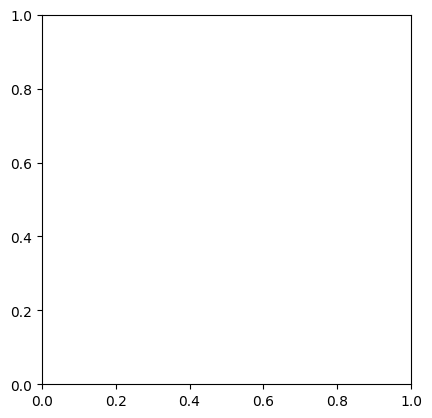

In [ ]:
import json
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from semseg.datasets import ADE20K

def load_labelme_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def compute_metrics(seg, gt):
    pixel_accuracy = (seg == gt).sum() / gt.size
    intersection = np.logical_and(seg == gt, gt > 0).sum()
    union = np.logical_or(seg > 0, gt > 0).sum()
    miou = intersection / (union + 1e-10)
    return pixel_accuracy, miou

def main(json_file, seg_tensor):
    labelme_data = load_labelme_json(json_file)

    # `gt` を (512, 512) のマスク画像として変換
    height, width = seg_tensor.shape[-2], seg_tensor.shape[-1]
    gt = np.zeros((height, width), dtype=np.uint8)

    # ラベルを登場順に番号付けする辞書
    label_mapping = {}
    current_label = 1  # 新しいラベル番号の開始

    for shape in labelme_data['shapes']:
        points = np.array(shape['points'], dtype=np.int32)
        label = shape['label']

        # ラベルがまだ出ていない場合、新しい番号を割り当て
        if label not in label_mapping:
            label_mapping[label] = current_label
            current_label += 1

        mapped_label = label_mapping[label]
        cv2.fillPoly(gt, [points], mapped_label)

    # 修正: seg_tensor を float32 に変換して softmax を適用し、明示的に shape を (512, 512) に維持
    seg = seg_tensor.to(torch.float32).softmax(dim=1).argmax(dim=1).cpu().numpy()

    # `seg` の形状を確認
    print(f"Before squeeze: seg shape = {seg.shape}")  # (1, 512, 512) のはず

    if seg.shape[0] == 1:
        seg = seg[0]  # (512, 512) に変換

    # 形状確認
    print(f"After squeeze: seg shape = {seg.shape}, gt shape = {gt.shape}")  # 両方とも (512, 512) になるはず

    # Pixel Accuracy と mIoU の計算
    pixel_accuracy, miou = compute_metrics(seg, gt)
    print(f'Pixel Accuracy: {pixel_accuracy:.4f}, mIoU: {miou:.4f}')

    # 結果の表示
    plt.imshow(seg, cmap='jet')  # セグメンテーション結果を表示
    plt.axis('off')
    plt.show()

# 使用例（適切な json_file と seg_tensor を指定する）
main("/content/drive/MyDrive/2025autum/02_Special_Laboratory/02_kosode/junk_box/14-D-201350-100-0057.json", seg)


In [ ]:
labelmeのjsonファイルでやり直し。

In [ ]:
import numpy as np
import torch
from PIL import Image, ImageDraw
import json
import matplotlib.pyplot as plt

# seg (セグメンテーション結果)
seg = torch.randn(1, 150, 512, 512)  # 例: shape: [1, 150, 512, 512]

# labelme JSONデータの読み込み
with open("/content/drive/MyDrive/2025autum/02_Special_Laboratory/02_kosode/junk_box/14-D-201350-100-0057.json") as f:
    json_data = json.load(f)

# ポリゴン座標を取得
points = json_data['shapes'][0]['points']
points = [tuple(point) for point in points]

# 画像サイズ
w, h = 512, 512  # サイズはデータに合わせて

# アノテーションのマスク画像作成
mask = Image.new('L', (w, h), 0)  # 背景は0 (黒)
draw = ImageDraw.Draw(mask)
draw.polygon(points, fill=1)  # 物体の領域を1 (白) に

# マスクをNumPyに変換
mask = np.array(mask)

# セグメンテーション結果を予測マスクに変換
# ここでは一番確信度が高いクラスを予測とみなす
seg_max = seg.argmax(dim=1).squeeze().cpu().numpy()

# Pixel Accuracyの計算
correct_pixels = np.sum(seg_max == mask)
total_pixels = mask.size
pixel_accuracy = correct_pixels / total_pixels

# IoUの計算
intersection = np.sum((seg_max == 1) & (mask == 1))
union = np.sum((seg_max == 1) | (mask == 1))
iou = intersection / union

# 結果表示
print(f'Pixel Accuracy: {pixel_accuracy:.4f}')
print(f'Mean IoU: {iou:.4f}')

# 可視化
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Ground Truth Mask')
plt.imshow(mask, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Predicted Segmentation')
plt.imshow(seg_max, cmap='gray')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'your_labelme_data.json'

segの仕組みを追加。

In [ ]:
import numpy as np
import torch
from PIL import Image, ImageDraw
import json
import matplotlib.pyplot as plt


# === 2. labelme JSON の読み込み ===
with open('/content/drive/MyDrive/2025autum/02_Special_Laboratory/02_kosode/junk_box/14-D-201350-100-0057.json') as f:
    json_data = json.load(f)

# === 3. ラベルを登場順に番号付け ===
label_map = {}
current_label_id = 1  # 1から開始

for shape in json_data['shapes']:
    label_name = shape['label']
    if label_name not in label_map:
        label_map[label_name] = current_label_id
        current_label_id += 1  # 新しいラベルが出るごとに番号を増やす

print("ラベルのマッピング:", label_map)  # 確認用

# === 3. JSON からマスク画像を作成 ===
w, h = 512, 512  # 画像サイズを固定
mask = Image.new('L', (w, h), 0)  # 背景は 0

draw = ImageDraw.Draw(mask)

for shape in json_data['shapes']:
    points = [tuple(p) for p in shape['points']]
    label_name = shape['label']  # ラベル名
    label_id = label_map.get(label_name, 0)  # ラベルをマップ、存在しなければ 0
    draw.polygon(points, fill=label_id)  # ポリゴン領域をラベル番号で埋める

mask = np.array(mask)  # PIL Image → NumPy配列（GTマスク）

# === 4. Pixel Accuracy の計算 ===
correct_pixels = np.sum(seg == mask)
total_pixels = mask.size
pixel_accuracy = correct_pixels / total_pixels

# === 5. Mean IoU (mIoU) の計算 ===
iou_list = []
for label in np.unique(mask):  # 存在するラベルごとにIoUを計算
    if label == 0:  # 背景クラスは除外
        continue
    intersection = np.sum((seg == label) & (mask == label))
    union = np.sum((seg == label) | (mask == label))
    if union == 0:
        iou = 0  # ゼロ割り防止
    else:
        iou = intersection / union
    iou_list.append(iou)

mean_iou = np.mean(iou_list) if iou_list else 0

# === 6. 結果を出力 ===
print(f'Pixel Accuracy: {pixel_accuracy:.4f}')
print(f'Mean IoU: {mean_iou:.4f}')

# === 7. 可視化 ===
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Ground Truth Mask')
plt.imshow(mask, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Predicted Segmentation')
plt.imshow(seg, cmap='gray')

plt.show()


ラベルを表示させる出力結果。

In [ ]:
import torch
import numpy as np
import cv2
from semseg.datasets import ADE20K  # 例として ADE20K を利用

# -------------------------
# ① セグメンテーション結果の後処理
# -------------------------
# ※ seg はネットワークの出力テンソルとします（例: [B, num_classes, H, W]）
#    ここではバッチサイズ1を前提としています。

# # 各ピクセルのクラスを softmax と argmax で求める
# seg = seg.softmax(1).argmax(1).to(torch.int)  # seg の shape は [1, H, W] になることを想定
# seg_unique = seg.unique()  # 画像内に現れるユニークなクラス番号

# -------------------------
# ② カラーパレットを用いたセグメンテーションマップの生成
# -------------------------
# ADE20K のパレット（色リスト）を取得
palette = ADE20K.PALETTE
# クラス名が定義されている場合（ADE20K.CLASSES など）：
classes = ADE20K.CLASSES if hasattr(ADE20K, 'CLASSES') else None

# seg の各画素に対してパレットの色を適用
# ※ palette[seg] の結果はテンソルで、形状は [1, H, W, 3] となることを想定
seg_map = palette[seg].squeeze().to(torch.uint8)  # shape: [H, W, 3]

# -------------------------
# ③ NumPy 配列に変換して各クラス領域に注釈を描画
# -------------------------
# テンソルを NumPy 配列へ変換（以降 OpenCV の描画処理のため）
seg_np = seg.squeeze().cpu().numpy()      # [H, W]（クラス番号）
seg_map_np = seg_map.cpu().numpy()          # [H, W, 3]（カラー画像）

# 画像のコピーを用意（注釈描画用）
annotated_img = seg_map_np.copy()

# ユニークな各クラス番号について処理
for cls in seg_unique.tolist():
    # 該当クラスのマスク作成
    mask = (seg_np == cls)
    if np.sum(mask) == 0:
        continue

    # マスク上のピクセル座標を取得
    coords = np.argwhere(mask)
    # 領域の左上と右下の座標（バウンディングボックス）を算出
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0)
    # バウンディングボックスの中心点を求める
    center_y, center_x = int((y0 + y1) / 2), int((x0 + x1) / 2)

    # クラス番号と、可能ならタグ名（クラス名）をテキストに
    label_text = f"{cls}"
    if classes is not None and cls < len(classes):
        label_text += f": {classes[cls]}"

    # OpenCV の putText 関数でテキストを描画
    # 第4引数はフォント、第5引数はフォントサイズ、(255,255,255) はテキスト色（白）
    cv2.putText(annotated_img, label_text, (center_x, center_y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255),
                thickness=1, lineType=cv2.LINE_AA)

# -------------------------
# ④ 結果の表示
# -------------------------
# ここでは show_image 関数を使って画像を表示します（実装は各自）
show_image(torch.from_numpy(annotated_img))


## Show Available Backbones

In [ ]:
from semseg import show_backbones

show_backbones()

## Show Available Heads

In [ ]:
from semseg import show_heads

show_heads()

## Show Available Datasets

In [ ]:
from semseg import show_datasets

show_datasets()

## Construct a Custom Model

### Choose a Backbone

In [ ]:
from semseg.models.backbones import ResNet

backbone = ResNet('18')

In [ ]:
# init random input batch
x = torch.randn(2, 3, 224, 224)

In [ ]:
# get features from the backbone
features = backbone(x)
for out in features:
    print(out.shape)

### Choose a Head

In [ ]:
from semseg.models.heads import UPerHead

head = UPerHead(backbone.channels, 128, num_classes=10)

In [ ]:
seg = head(features)
seg.shape

In [ ]:
from torch.nn import functional as F
# upsample the output
seg = F.interpolate(seg, size=x.shape[-2:], mode='bilinear', align_corners=False)
seg.shape

Check `semseg/models/custom_cnn.py` and `semseg/models/custom_vit.py` for a complete construction for custom model.